In [1]:
import numpy as np
import pandas as pd
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
import json
from sklearn.preprocessing import StandardScaler

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split

In [3]:
instances_dict_path = './instances_dict.json'
with open(instances_dict_path, 'r') as f:
    instances_dict = json.load(f)

smoothpur_1_4 = np.load('Artificial_data/SmoothPur_1_4.npy')
smoothpur_5_8 = np.load('Artificial_data/SmoothPur_5_8.npy')
smoothpur_9_10 = np.load('Artificial_data/SmoothPur_9_10.npy')
smoothpur_11_12 = np.load('Artificial_data/SmoothPur_11_12.npy')

print(instances_dict)
print('length of instances_dict : ' ,len(instances_dict))
print('-' * 100)
print('length of smoothpur_1_4 : ' ,len(smoothpur_1_4))
print('length of smoothpur_5_8 : ' ,len(smoothpur_5_8))
print('length of smoothpur_9_10 : ' ,len(smoothpur_9_10))
print('length of smoothpur_11_12 : ' ,len(smoothpur_11_12))
print('-' * 100)
print('type of smoothpur_1_4 : ' , type(smoothpur_1_4))
print('type of smoothpur_5_8 : ' , type(smoothpur_5_8))
print('type of smoothpur_9_10 : ' , type(smoothpur_9_10))
print('type of smoothpur_11_12 : ' , type(smoothpur_11_12))
print('-' * 100)
print('shape of smoothpur_1_4 : ' , smoothpur_1_4.shape)
print('shape of smoothpur_5_8 : ' , smoothpur_5_8.shape)
print('shape of smoothpur_9_10 : ' , smoothpur_9_10.shape)
print('shape of smoothpur_11_12 : ' , smoothpur_11_12.shape)

{'0': 'HF008', '1': 'HF008_V2', '2': 'HF009', '3': 'HF009_V2', '4': 'HF010', '5': 'HF010_V2', '6': 'HF011', '7': 'HF011_V2', '8': 'HF012', '9': 'HF012_V2', '10': 'HF013', '11': 'HF014', '12': 'HF015', '13': 'HF015_V2', '14': 'HF016', '15': 'HF016_V2', '16': 'HF017', '17': 'HF018', '18': 'HF019', '19': 'HF020', '20': 'HF021', '21': 'HF022', '22': 'HF023', '23': 'HF024', '24': 'HF026', '25': 'HF026_V2', '26': 'HF027', '27': 'HF027_V2', '28': 'HF028', '29': 'HF029', '30': 'HF030_V2', '31': 'HF031', '32': 'HF031_V2', '33': 'HF032', '34': 'HF032_V2', '35': 'HF033', '36': 'HF033_V2', '37': 'HG001', '38': 'HG001_V2', '39': 'HG002', '40': 'HG002_V2', '41': 'HG003', '42': 'HG003_V2', '43': 'HG004', '44': 'HG004_V2', '45': 'HG005', '46': 'HG005_V2', '47': 'HG005_V3', '48': 'HG006_V2', '49': 'HG008', '50': 'HG008_V2', '51': 'HG009', '52': 'HG009_V2', '53': 'HG010', '54': 'HG010_V2', '55': 'HG011', '56': 'HG011_V2', '57': 'HG012_V2', '58': 'HG014_V2', '59': 'HG015', '60': 'HG015_V2', '61': 'HG016'

In [5]:
def flatten_smoothpur_1_8(original_arr):
    arr_shape = original_arr.shape
    flattened_list = []
    for i in range(arr_shape[0]):
      for j in range(arr_shape[1]):
        flattened_list.append(original_arr[i][j][0])
        flattened_list.append(original_arr[i][j][1])
    flattened_arr = np.array(flattened_list)
    return flattened_arr

In [7]:
def flatten_smoothpur_9_12(original_arr):
    arr_shape = original_arr.shape
    flattened_x_list = []
    flattened_y_list = []
    for i in range(arr_shape[0]):
      for j in range(arr_shape[1]):
        flattened_x_list.append(original_arr[i][j][0][0])
        flattened_x_list.append(original_arr[i][j][0][1])
        flattened_y_list.append(original_arr[i][j][1][0])
        flattened_y_list.append(original_arr[i][j][1][1])
    flattened_x_arr = np.array(flattened_x_list)
    flattened_y_arr = np.array(flattened_y_list)
    return flattened_x_arr, flattened_y_arr

In [9]:
def downsample(signals, new_len):
    downsampled_signals = []
    for signal in signals:
        signal = signal.reshape(-1)  # Flatten the signal
        downsample_factor = len(signal) // new_len
        indices = np.arange(0, len(signal), downsample_factor)
        downsampled_signal = signal[indices[:new_len]]  # Ensure the length matches new_len
        downsampled_signals.append(downsampled_signal)
    return np.array(downsampled_signals)

In [11]:
newL = 1500

flat_1_4 = flatten_smoothpur_1_8(smoothpur_1_4)
flat_5_8 = flatten_smoothpur_1_8(smoothpur_5_8)
flat_x_9_10, flat_y_9_10 = flatten_smoothpur_9_12(smoothpur_9_10)
flat_x_11_12, flat_y_11_12 = flatten_smoothpur_9_12(smoothpur_11_12)

mean_1_4 = np.nanmean(flat_1_4)
std_1_4 = np.nanstd(flat_1_4)
flat_1_4_normalized = (flat_1_4 - mean_1_4) / std_1_4

mean_5_8 = np.nanmean(flat_5_8)
std_5_8 = np.nanstd(flat_5_8)
flat_5_8_normalized = (flat_5_8 - mean_5_8) / std_5_8

mean_x_9_10 = np.nanmean(flat_x_9_10)
std_x_9_10 = np.nanstd(flat_x_9_10)
flat_x_9_10_normalized = (flat_x_9_10 - mean_x_9_10) / std_x_9_10

mean_y_9_10 = np.nanmean(flat_y_9_10)
std_y_9_10 = np.nanstd(flat_y_9_10)
flat_y_9_10_normalized = (flat_y_9_10 - mean_y_9_10) / std_y_9_10

mean_x_11_12 = np.nanmean(flat_x_11_12)
std_x_11_12 = np.nanstd(flat_x_11_12)
flat_x_11_12_normalized = (flat_x_11_12 - mean_x_11_12) / std_x_11_12

mean_y_11_12 = np.nanmean(flat_y_11_12)
std_y_11_12 = np.nanstd(flat_y_11_12)
flat_y_11_12_normalized = (flat_y_11_12 - mean_y_11_12) / std_y_11_12

down_1_4 = downsample(flat_1_4_normalized, newL)
down_5_8 = downsample(flat_5_8_normalized, newL)
down_x_9_10, down_y_9_10 = downsample(flat_x_9_10_normalized, newL), downsample(flat_y_9_10_normalized, newL)
down_x_11_12, down_y_11_12 = downsample(flat_x_11_12_normalized, newL), downsample(flat_y_11_12_normalized, newL)

print('shape of flattened smoothpur_1_4 :', flat_1_4_normalized.shape)
print('shape of flattened smoothpur_5_8 :', flat_5_8_normalized.shape)
print('shape of flattened smoothpur_x_9_10 :', flat_x_9_10_normalized.shape)
print('shape of flattened smoothpur_y_9_10 :', flat_y_9_10_normalized.shape)
print('shape of flattened smoothpur_x_11_12 :', flat_x_11_12_normalized.shape)
print('shape of flattened smoothpur_y_11_12 :', flat_y_11_12_normalized.shape)
print('-' * 100)
print('shape of downsampled smoothpur_1_4 :', down_1_4.shape)
print('shape of downsampled smoothpur_5_8 :', down_5_8.shape)
print('shape of downsampled smoothpur_x_9_10 :', down_x_9_10.shape)
print('shape of downsampled smoothpur_y_9_10 :', down_y_9_10.shape)
print('shape of downsampled smoothpur_x_11_12 :', down_x_11_12.shape)
print('shape of downsampled smoothpur_y_11_12 :', down_y_11_12.shape)

shape of flattened smoothpur_1_4 : (1376, 15000)
shape of flattened smoothpur_5_8 : (1376, 15000)
shape of flattened smoothpur_x_9_10 : (688, 15000)
shape of flattened smoothpur_y_9_10 : (688, 15000)
shape of flattened smoothpur_x_11_12 : (688, 15000)
shape of flattened smoothpur_y_11_12 : (688, 15000)
----------------------------------------------------------------------------------------------------
shape of downsampled smoothpur_1_4 : (1376, 1500)
shape of downsampled smoothpur_5_8 : (1376, 1500)
shape of downsampled smoothpur_x_9_10 : (688, 1500)
shape of downsampled smoothpur_y_9_10 : (688, 1500)
shape of downsampled smoothpur_x_11_12 : (688, 1500)
shape of downsampled smoothpur_y_11_12 : (688, 1500)


In [13]:
# Process flat_1_4
long_signals_1_4 = []
idxs_1_4 = []
for idx, i in enumerate(flat_1_4_normalized):
    if not np.isnan(i).sum():  # Check if there are no NaN values
        idxs_1_4.append(idx)
        long_signals_1_4.append(i)

short_signals_1_4 = [down_1_4[idx] for idx in idxs_1_4]

# Convert lists to numpy arrays
long_signals_1_4 = np.array(long_signals_1_4)
short_signals_1_4 = np.array(short_signals_1_4)

# Process flat_5_8
long_signals_5_8 = []
idxs_5_8 = []
for idx, i in enumerate(flat_5_8_normalized):
    if not np.isnan(i).sum():  # Check if there are no NaN values
        idxs_5_8.append(idx)
        long_signals_5_8.append(i)

short_signals_5_8 = [down_5_8[idx] for idx in idxs_5_8]

# Convert lists to numpy arrays
long_signals_5_8 = np.array(long_signals_5_8)
short_signals_5_8 = np.array(short_signals_5_8)

# Process flat_x_9_10
long_signals_x_9_10 = []
idxs_x_9_10 = []
for idx, i in enumerate(flat_x_9_10_normalized):
    if not np.isnan(i).sum():  # Check if there are no NaN values
        idxs_x_9_10.append(idx)
        long_signals_x_9_10.append(i)

short_signals_x_9_10 = [down_x_9_10[idx] for idx in idxs_x_9_10]

# Convert lists to numpy arrays
long_signals_x_9_10 = np.array(long_signals_x_9_10)
short_signals_x_9_10 = np.array(short_signals_x_9_10)

# Process flat_y_9_10
long_signals_y_9_10 = []
idxs_y_9_10 = []
for idx, i in enumerate(flat_y_9_10_normalized):
    if not np.isnan(i).sum():  # Check if there are no NaN values
        idxs_y_9_10.append(idx)
        long_signals_y_9_10.append(i)

short_signals_y_9_10 = [down_y_9_10[idx] for idx in idxs_y_9_10]

# Convert lists to numpy arrays
long_signals_y_9_10 = np.array(long_signals_y_9_10)
short_signals_y_9_10 = np.array(short_signals_y_9_10)

# Process flat_x_11_12
long_signals_x_11_12 = []
idxs_x_11_12 = []
for idx, i in enumerate(flat_x_11_12_normalized):
    if not np.isnan(i).sum():  # Check if there are no NaN values
        idxs_x_11_12.append(idx)
        long_signals_x_11_12.append(i)

short_signals_x_11_12 = [down_x_11_12[idx] for idx in idxs_x_11_12]

# Convert lists to numpy arrays
long_signals_x_11_12 = np.array(long_signals_x_11_12)
short_signals_x_11_12 = np.array(short_signals_x_11_12)

# Process flat_y_11_12
long_signals_y_11_12 = []
idxs_y_11_12 = []
for idx, i in enumerate(flat_y_11_12_normalized):
    if not np.isnan(i).sum():  # Check if there are no NaN values
        idxs_y_11_12.append(idx)
        long_signals_y_11_12.append(i)

short_signals_y_11_12 = [down_y_11_12[idx] for idx in idxs_y_11_12]

# Convert lists to numpy arrays
long_signals_y_11_12 = np.array(long_signals_y_11_12)
short_signals_y_11_12 = np.array(short_signals_y_11_12)

# Append all long signals and short signals
long_signals = np.concatenate([
    long_signals_1_4,
    long_signals_5_8,
    long_signals_x_9_10,
    long_signals_y_9_10,
    long_signals_x_11_12,
    long_signals_y_11_12
], axis=0)

short_signals = np.concatenate([
    short_signals_1_4,
    short_signals_5_8,
    short_signals_x_9_10,
    short_signals_y_9_10,
    short_signals_x_11_12,
    short_signals_y_11_12
], axis=0)



In [15]:
import numpy as np
from scipy.interpolate import interp1d
import torch

def initial_upsampling(downsampled_signals, target_length):
    upsampled_signals = []
    for signal in downsampled_signals:
        x_old = np.linspace(0, 1, len(signal))
        x_new = np.linspace(0, 1, target_length)
        interpolator = interp1d(x_old, signal, kind='cubic')  # You can use 'linear' or 'cubic'
        upsampled_signal = interpolator(x_new)
        upsampled_signals.append(upsampled_signal)
    return np.array(upsampled_signals)

# Example data generation (replace with your actual data)
downsampled_signals = short_signals.astype(np.float32)
original_signals = long_signals.astype(np.float32)

# Initial Upsampling
initial_upsampled_signals = initial_upsampling(downsampled_signals, target_length=15000)

# # Convert numpy arrays to PyTorch tensors with float32
initial_upsampled_signals = torch.tensor(initial_upsampled_signals, dtype=torch.float32)
original_signals = torch.tensor(original_signals, dtype=torch.float32)

print(f"Initial upsampled signals shape: {initial_upsampled_signals.shape}")
print(f"Original signals shape: {original_signals.shape}")

Initial upsampled signals shape: torch.Size([3112, 15000])
Original signals shape: torch.Size([3112, 15000])


In [17]:
import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import interact

def plot_interpolation(signal_idx):
    upsampled_signal = initial_upsampled_signals[signal_idx].numpy()
    original_signal = original_signals[signal_idx].numpy()

    # Calculate MSE loss
    mse_loss = np.mean((upsampled_signal - original_signal) ** 2)

    plt.figure(figsize=(18, 8))
    plt.plot(upsampled_signal, label='Upsampled Signal')
    plt.plot(original_signal, label='Original Signal', alpha=0.7)
    plt.title(f'Signal {signal_idx} - MSE Loss: {mse_loss:.4f}')
    plt.legend()
    plt.show()

# Create an interactive widget
interact(plot_interpolation, signal_idx=widgets.IntSlider(min=0, max=733, step=1, value=0))

interactive(children=(IntSlider(value=0, description='signal_idx', max=733), Output()), _dom_classes=('widget-…

<function __main__.plot_interpolation(signal_idx)>

cuda


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [1/300], Train Loss: 0.140463, Val Loss: 0.039527
Validation loss decreased (0.039527). Saving model...


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [2/300], Train Loss: 0.004962, Val Loss: 0.001450
Validation loss decreased (0.001450). Saving model...


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [3/300], Train Loss: 0.004352, Val Loss: 0.001226
Validation loss decreased (0.001226). Saving model...


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [4/300], Train Loss: 0.002898, Val Loss: 0.000812
Validation loss decreased (0.000812). Saving model...


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [5/300], Train Loss: 0.003451, Val Loss: 0.000952


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [6/300], Train Loss: 0.003717, Val Loss: 0.000828


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [7/300], Train Loss: 0.003833, Val Loss: 0.001059


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [8/300], Train Loss: 0.003700, Val Loss: 0.000697
Validation loss decreased (0.000697). Saving model...


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [9/300], Train Loss: 0.003142, Val Loss: 0.000576
Validation loss decreased (0.000576). Saving model...


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [10/300], Train Loss: 0.003440, Val Loss: 0.000567
Validation loss decreased (0.000567). Saving model...


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [11/300], Train Loss: 0.003319, Val Loss: 0.000664


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [12/300], Train Loss: 0.003570, Val Loss: 0.000460
Validation loss decreased (0.000460). Saving model...


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [13/300], Train Loss: 0.003133, Val Loss: 0.000429
Validation loss decreased (0.000429). Saving model...


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [14/300], Train Loss: 0.003645, Val Loss: 0.000723


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [15/300], Train Loss: 0.003662, Val Loss: 0.000539


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [16/300], Train Loss: 0.003248, Val Loss: 0.000397
Validation loss decreased (0.000397). Saving model...


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [17/300], Train Loss: 0.002897, Val Loss: 0.000439


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [18/300], Train Loss: 0.003113, Val Loss: 0.000476


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [19/300], Train Loss: 0.003979, Val Loss: 0.001271


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [20/300], Train Loss: 0.003101, Val Loss: 0.000391
Validation loss decreased (0.000391). Saving model...


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [21/300], Train Loss: 0.003511, Val Loss: 0.000399


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [22/300], Train Loss: 0.003278, Val Loss: 0.000390
Validation loss decreased (0.000390). Saving model...


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [23/300], Train Loss: 0.002910, Val Loss: 0.000493


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [24/300], Train Loss: 0.002989, Val Loss: 0.000758


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [25/300], Train Loss: 0.003629, Val Loss: 0.000564


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [26/300], Train Loss: 0.004232, Val Loss: 0.000547


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [27/300], Train Loss: 0.002657, Val Loss: 0.000473


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [28/300], Train Loss: 0.003297, Val Loss: 0.000440


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [29/300], Train Loss: 0.003238, Val Loss: 0.000352
Validation loss decreased (0.000352). Saving model...


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [30/300], Train Loss: 0.003563, Val Loss: 0.000687


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [31/300], Train Loss: 0.002912, Val Loss: 0.000896


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [32/300], Train Loss: 0.003411, Val Loss: 0.000360


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [33/300], Train Loss: 0.003235, Val Loss: 0.000318
Validation loss decreased (0.000318). Saving model...


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [34/300], Train Loss: 0.002844, Val Loss: 0.000404


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [35/300], Train Loss: 0.002801, Val Loss: 0.001020


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [36/300], Train Loss: 0.003386, Val Loss: 0.000426


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [37/300], Train Loss: 0.002892, Val Loss: 0.000974


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [38/300], Train Loss: 0.003108, Val Loss: 0.000347


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [39/300], Train Loss: 0.002709, Val Loss: 0.000398


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [40/300], Train Loss: 0.003040, Val Loss: 0.000328


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [41/300], Train Loss: 0.002714, Val Loss: 0.000361


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [42/300], Train Loss: 0.002607, Val Loss: 0.000512


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [43/300], Train Loss: 0.002927, Val Loss: 0.000691


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [44/300], Train Loss: 0.003613, Val Loss: 0.000539


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [45/300], Train Loss: 0.002900, Val Loss: 0.000322


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [46/300], Train Loss: 0.002762, Val Loss: 0.000845


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [47/300], Train Loss: 0.002779, Val Loss: 0.000361


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [48/300], Train Loss: 0.003708, Val Loss: 0.000534


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [49/300], Train Loss: 0.003095, Val Loss: 0.000327


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [50/300], Train Loss: 0.002601, Val Loss: 0.000382


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [51/300], Train Loss: 0.002996, Val Loss: 0.000595


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [52/300], Train Loss: 0.003322, Val Loss: 0.000321


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [53/300], Train Loss: 0.003054, Val Loss: 0.000370


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [54/300], Train Loss: 0.003061, Val Loss: 0.000327


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [55/300], Train Loss: 0.002709, Val Loss: 0.000286
Validation loss decreased (0.000286). Saving model...


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [56/300], Train Loss: 0.002650, Val Loss: 0.000293


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [57/300], Train Loss: 0.003092, Val Loss: 0.000301


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [58/300], Train Loss: 0.002573, Val Loss: 0.000287


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [59/300], Train Loss: 0.002665, Val Loss: 0.000449


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [60/300], Train Loss: 0.002693, Val Loss: 0.000326


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [61/300], Train Loss: 0.002578, Val Loss: 0.000367


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [62/300], Train Loss: 0.003090, Val Loss: 0.000307


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [63/300], Train Loss: 0.002720, Val Loss: 0.000353


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [64/300], Train Loss: 0.003201, Val Loss: 0.000288


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [65/300], Train Loss: 0.002919, Val Loss: 0.000598


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [66/300], Train Loss: 0.002686, Val Loss: 0.000347


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [67/300], Train Loss: 0.002795, Val Loss: 0.000420


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [68/300], Train Loss: 0.003291, Val Loss: 0.000345


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [69/300], Train Loss: 0.002618, Val Loss: 0.000294


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [70/300], Train Loss: 0.002990, Val Loss: 0.000562


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [71/300], Train Loss: 0.002604, Val Loss: 0.000393


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [72/300], Train Loss: 0.002910, Val Loss: 0.000315


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [73/300], Train Loss: 0.002543, Val Loss: 0.000299


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [74/300], Train Loss: 0.002983, Val Loss: 0.000340


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [75/300], Train Loss: 0.002800, Val Loss: 0.000283
Validation loss decreased (0.000283). Saving model...


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [76/300], Train Loss: 0.003368, Val Loss: 0.000609


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [77/300], Train Loss: 0.002464, Val Loss: 0.000419


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [78/300], Train Loss: 0.002609, Val Loss: 0.000273
Validation loss decreased (0.000273). Saving model...


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [79/300], Train Loss: 0.003011, Val Loss: 0.000347


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [80/300], Train Loss: 0.002646, Val Loss: 0.000412


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [81/300], Train Loss: 0.002713, Val Loss: 0.000492


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [82/300], Train Loss: 0.003066, Val Loss: 0.000506


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [83/300], Train Loss: 0.002958, Val Loss: 0.000341


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [84/300], Train Loss: 0.002285, Val Loss: 0.000291


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [85/300], Train Loss: 0.002123, Val Loss: 0.000311


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [86/300], Train Loss: 0.002998, Val Loss: 0.000341


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [87/300], Train Loss: 0.002345, Val Loss: 0.000409


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [88/300], Train Loss: 0.003122, Val Loss: 0.000351


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [89/300], Train Loss: 0.002669, Val Loss: 0.000303


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [90/300], Train Loss: 0.003088, Val Loss: 0.000275


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [91/300], Train Loss: 0.002738, Val Loss: 0.000810


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [92/300], Train Loss: 0.002723, Val Loss: 0.000315


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [93/300], Train Loss: 0.002720, Val Loss: 0.000428


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [94/300], Train Loss: 0.002993, Val Loss: 0.000383


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [95/300], Train Loss: 0.002660, Val Loss: 0.000417


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [96/300], Train Loss: 0.002521, Val Loss: 0.000539


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [97/300], Train Loss: 0.002489, Val Loss: 0.000350


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [98/300], Train Loss: 0.002885, Val Loss: 0.000528


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [99/300], Train Loss: 0.002917, Val Loss: 0.000275


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [100/300], Train Loss: 0.002589, Val Loss: 0.000348


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [101/300], Train Loss: 0.002198, Val Loss: 0.000346


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [102/300], Train Loss: 0.002480, Val Loss: 0.000324


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [103/300], Train Loss: 0.002886, Val Loss: 0.000267
Validation loss decreased (0.000267). Saving model...


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [104/300], Train Loss: 0.002180, Val Loss: 0.000262
Validation loss decreased (0.000262). Saving model...


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [105/300], Train Loss: 0.002670, Val Loss: 0.000445


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [106/300], Train Loss: 0.002778, Val Loss: 0.000435


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [107/300], Train Loss: 0.002958, Val Loss: 0.000500


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [108/300], Train Loss: 0.002346, Val Loss: 0.000258
Validation loss decreased (0.000258). Saving model...


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [109/300], Train Loss: 0.002630, Val Loss: 0.000529


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [110/300], Train Loss: 0.002441, Val Loss: 0.000403


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [111/300], Train Loss: 0.002609, Val Loss: 0.000298


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [112/300], Train Loss: 0.002720, Val Loss: 0.000263


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [113/300], Train Loss: 0.002493, Val Loss: 0.000369


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [114/300], Train Loss: 0.002236, Val Loss: 0.000330


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [115/300], Train Loss: 0.002545, Val Loss: 0.000290


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [116/300], Train Loss: 0.001877, Val Loss: 0.000303


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [117/300], Train Loss: 0.002517, Val Loss: 0.000340


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [118/300], Train Loss: 0.002314, Val Loss: 0.000424


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [119/300], Train Loss: 0.001935, Val Loss: 0.000353


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [120/300], Train Loss: 0.002396, Val Loss: 0.000272


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [121/300], Train Loss: 0.002431, Val Loss: 0.000295


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [122/300], Train Loss: 0.002439, Val Loss: 0.000290


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [123/300], Train Loss: 0.002594, Val Loss: 0.000316


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [124/300], Train Loss: 0.002285, Val Loss: 0.000317


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [125/300], Train Loss: 0.002389, Val Loss: 0.000300


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [126/300], Train Loss: 0.002608, Val Loss: 0.000338


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [127/300], Train Loss: 0.003006, Val Loss: 0.000333


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [128/300], Train Loss: 0.002782, Val Loss: 0.000601


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [129/300], Train Loss: 0.002795, Val Loss: 0.000399


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [130/300], Train Loss: 0.002203, Val Loss: 0.000285


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [131/300], Train Loss: 0.002431, Val Loss: 0.000387


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [132/300], Train Loss: 0.002785, Val Loss: 0.000283


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [133/300], Train Loss: 0.002745, Val Loss: 0.000316


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [134/300], Train Loss: 0.002486, Val Loss: 0.000383


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [135/300], Train Loss: 0.002264, Val Loss: 0.000416


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [136/300], Train Loss: 0.002194, Val Loss: 0.000300


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [137/300], Train Loss: 0.002054, Val Loss: 0.000379


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [138/300], Train Loss: 0.002163, Val Loss: 0.000363


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [139/300], Train Loss: 0.002254, Val Loss: 0.000365


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [140/300], Train Loss: 0.002903, Val Loss: 0.000307


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [141/300], Train Loss: 0.002399, Val Loss: 0.000369


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [142/300], Train Loss: 0.002600, Val Loss: 0.000288


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [143/300], Train Loss: 0.002318, Val Loss: 0.000546


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [144/300], Train Loss: 0.002377, Val Loss: 0.000293


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [145/300], Train Loss: 0.002093, Val Loss: 0.000293


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [146/300], Train Loss: 0.002562, Val Loss: 0.000364


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [147/300], Train Loss: 0.002454, Val Loss: 0.000275


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [148/300], Train Loss: 0.002239, Val Loss: 0.000283


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [149/300], Train Loss: 0.002188, Val Loss: 0.000304


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [150/300], Train Loss: 0.002514, Val Loss: 0.000485


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [151/300], Train Loss: 0.002249, Val Loss: 0.000304


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [152/300], Train Loss: 0.002442, Val Loss: 0.000292


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [153/300], Train Loss: 0.002337, Val Loss: 0.000308


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [154/300], Train Loss: 0.002281, Val Loss: 0.000423


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [155/300], Train Loss: 0.002097, Val Loss: 0.000301


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [156/300], Train Loss: 0.002625, Val Loss: 0.000335


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [157/300], Train Loss: 0.001952, Val Loss: 0.000298


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [158/300], Train Loss: 0.002537, Val Loss: 0.000676
Early stopping!


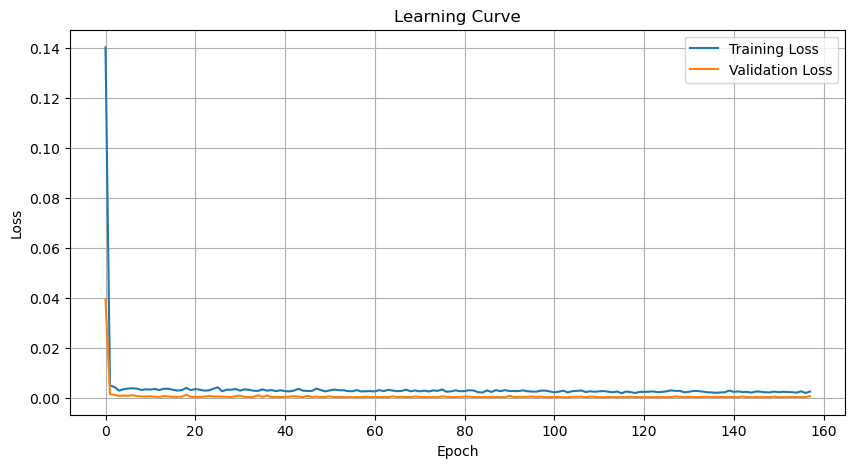

In [19]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
import numpy as np
from tqdm.notebook import tqdm
import torch.nn.functional as F
import matplotlib.pyplot as plt  # Import matplotlib for plotting

# Ensure reproducibility
torch.manual_seed(42)
np.random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

# Prepare Dataset and DataLoader
dataset = TensorDataset(initial_upsampled_signals, original_signals)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

batch_size = 32  # You can adjust this value
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


class ImprovedAutoencoder(nn.Module):
    def __init__(self):
        super(ImprovedAutoencoder, self).__init__()
        # Encoder
        self.encoder_conv1 = nn.Conv1d(1, 32, kernel_size=3, stride=1, padding=1)
        self.encoder_bn1 = nn.BatchNorm1d(32)
        
        self.encoder_conv2 = nn.Conv1d(32, 64, kernel_size=3, stride=2, padding=1)  # Downsample
        self.encoder_bn2 = nn.BatchNorm1d(64)
        
        self.encoder_conv3 = nn.Conv1d(64, 128, kernel_size=3, stride=2, padding=1)  # Downsample
        self.encoder_bn3 = nn.BatchNorm1d(128)
        
        self.encoder_conv4 = nn.Conv1d(128, 256, kernel_size=3, stride=2, padding=1)  # Downsample
        self.encoder_bn4 = nn.BatchNorm1d(256)
        
        self.relu = nn.ReLU()
        # self.dropout = nn.Dropout(0.1)
    
        # Decoder
        self.decoder_convtrans1 = nn.ConvTranspose1d(256, 128, kernel_size=4, stride=2, padding=1)  # Upsample
        self.decoder_bn1 = nn.BatchNorm1d(128)
        
        self.decoder_convtrans2 = nn.ConvTranspose1d(128, 64, kernel_size=4, stride=2, padding=1)  # Upsample
        self.decoder_bn2 = nn.BatchNorm1d(64)
        
        self.decoder_convtrans3 = nn.ConvTranspose1d(64, 32, kernel_size=4, stride=2, padding=1)  # Upsample
        self.decoder_bn3 = nn.BatchNorm1d(32)
        
        self.decoder_conv1 = nn.Conv1d(32, 1, kernel_size=3, stride=1, padding=1)  # Output layer
        
    def forward(self, x):
        # Encoder
        x1 = self.encoder_conv1(x)
        x1 = self.encoder_bn1(x1)
        x1 = self.relu(x1)
        # x1 = self.dropout(x1)
        
        x2 = self.encoder_conv2(x1)
        x2 = self.encoder_bn2(x2)
        x2 = self.relu(x2)
        # x2 = self.dropout(x2)
        
        x3 = self.encoder_conv3(x2)
        x3 = self.encoder_bn3(x3)
        x3 = self.relu(x3)
        # x3 = self.dropout(x3)
        
        x4 = self.encoder_conv4(x3)
        x4 = self.encoder_bn4(x4)
        x4 = self.relu(x4)
        # x4 = self.dropout(x4)
        
        # Decoder
        x = self.decoder_convtrans1(x4)
        x = self.decoder_bn1(x)
        x = self.relu(x)
        # x = self.dropout(x)
        
        # Add skip connection from x3
        if x3.size(2) != x.size(2):
            x3 = F.interpolate(x3, size=x.size(2))
        x = x + x3
        
        x = self.decoder_convtrans2(x)
        x = self.decoder_bn2(x)
        x = self.relu(x)
        # x = self.dropout(x)
        
        # Add skip connection from x2
        if x2.size(2) != x.size(2):
            x2 = F.interpolate(x2, size=x.size(2))
        x = x + x2
        
        x = self.decoder_convtrans3(x)
        x = self.decoder_bn3(x)
        x = self.relu(x)
        # x = self.dropout(x)
        
        # Add skip connection from x1
        if x1.size(2) != x.size(2):
            x1 = F.interpolate(x1, size=x.size(2))
        x = x + x1
        
        # Output layer
        x = self.decoder_conv1(x)
        return x

# Instantiate the model
model = ImprovedAutoencoder()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define Loss and Optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=5e-5, weight_decay=1e-5)

# Learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=20, factor=0.5)

# Initialize lists to store losses
train_losses = []
val_losses = []

# Training Loop with Early Stopping
num_epochs = 300
patience = 50  # Early stopping patience
best_val_loss = float('inf')
epochs_no_improve = 0
best_model_wts = None

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for upsampled, original in tqdm(train_loader):
        upsampled = upsampled.unsqueeze(1).to(device)  # Add channel dimension
        original = original.unsqueeze(1).to(device)

        optimizer.zero_grad()
        outputs = model(upsampled)
        loss = criterion(outputs, original)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * upsampled.size(0)

    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)  # Append training loss

    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for upsampled, original in val_loader:
            upsampled = upsampled.unsqueeze(1).to(device)
            original = original.unsqueeze(1).to(device)

            outputs = model(upsampled)
            loss = criterion(outputs, original)
            val_loss += loss.item() * upsampled.size(0)

    val_loss /= len(val_loader.dataset)
    val_losses.append(val_loss)  # Append validation loss
    scheduler.step(val_loss)

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.6f}, Val Loss: {val_loss:.6f}')

    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0
        best_model_wts = model.state_dict()
        torch.save(model.state_dict(), 'best_improved_autoencoder_1500.pth')
        print(f'Validation loss decreased ({best_val_loss:.6f}). Saving model...')
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print('Early stopping!')
            break

# Load the best model weights
model.load_state_dict(best_model_wts)

# Plot the learning curve
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Learning Curve')
plt.legend()
plt.grid(True)

# Save the figure
plt.savefig('learning_curve.png', dpi=300, bbox_inches='tight')  # Save as a .png file with high resolution


plt.show()

# Evaluation on the full dataset (Optional)
model.eval()
with torch.no_grad():
    upsampled_signals = initial_upsampled_signals.unsqueeze(1).to(device)
    outputs = model(upsampled_signals)
    refined_signals = outputs.squeeze(1).cpu()


cuda


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [1/300], Train Loss: 0.141399, Val Loss: 0.043773
Validation loss decreased (0.043773). Saving model...


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [2/300], Train Loss: 0.007010, Val Loss: 0.003516
Validation loss decreased (0.003516). Saving model...


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [3/300], Train Loss: 0.006280, Val Loss: 0.003309
Validation loss decreased (0.003309). Saving model...


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [4/300], Train Loss: 0.004783, Val Loss: 0.002691
Validation loss decreased (0.002691). Saving model...


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [5/300], Train Loss: 0.005309, Val Loss: 0.003060


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [6/300], Train Loss: 0.005528, Val Loss: 0.002695


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [7/300], Train Loss: 0.005607, Val Loss: 0.002981


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [8/300], Train Loss: 0.005469, Val Loss: 0.002414
Validation loss decreased (0.002414). Saving model...


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [9/300], Train Loss: 0.004873, Val Loss: 0.002298
Validation loss decreased (0.002298). Saving model...


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [10/300], Train Loss: 0.005153, Val Loss: 0.002258
Validation loss decreased (0.002258). Saving model...


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [11/300], Train Loss: 0.005015, Val Loss: 0.002416


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [12/300], Train Loss: 0.005276, Val Loss: 0.002148
Validation loss decreased (0.002148). Saving model...


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [13/300], Train Loss: 0.004801, Val Loss: 0.002144
Validation loss decreased (0.002144). Saving model...


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [14/300], Train Loss: 0.005312, Val Loss: 0.002300


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [15/300], Train Loss: 0.005305, Val Loss: 0.002194


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [16/300], Train Loss: 0.004912, Val Loss: 0.002031
Validation loss decreased (0.002031). Saving model...


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [17/300], Train Loss: 0.004519, Val Loss: 0.002064


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [18/300], Train Loss: 0.004741, Val Loss: 0.002201


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [19/300], Train Loss: 0.005609, Val Loss: 0.003485


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [20/300], Train Loss: 0.004703, Val Loss: 0.001940
Validation loss decreased (0.001940). Saving model...


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [21/300], Train Loss: 0.005090, Val Loss: 0.001998


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [22/300], Train Loss: 0.004881, Val Loss: 0.002008


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [23/300], Train Loss: 0.004504, Val Loss: 0.002144


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [24/300], Train Loss: 0.004542, Val Loss: 0.002632


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [25/300], Train Loss: 0.005191, Val Loss: 0.002240


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [26/300], Train Loss: 0.005797, Val Loss: 0.002161


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [27/300], Train Loss: 0.004206, Val Loss: 0.002040


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [28/300], Train Loss: 0.004864, Val Loss: 0.001995


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [29/300], Train Loss: 0.004789, Val Loss: 0.001918
Validation loss decreased (0.001918). Saving model...


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [30/300], Train Loss: 0.005110, Val Loss: 0.002325


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [31/300], Train Loss: 0.004436, Val Loss: 0.002604


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [32/300], Train Loss: 0.004941, Val Loss: 0.001925


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [33/300], Train Loss: 0.004762, Val Loss: 0.001883
Validation loss decreased (0.001883). Saving model...


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [34/300], Train Loss: 0.004360, Val Loss: 0.001947


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [35/300], Train Loss: 0.004312, Val Loss: 0.002813


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [36/300], Train Loss: 0.004906, Val Loss: 0.002003


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [37/300], Train Loss: 0.004417, Val Loss: 0.002829


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [38/300], Train Loss: 0.004624, Val Loss: 0.001910


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [39/300], Train Loss: 0.004215, Val Loss: 0.001923


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [40/300], Train Loss: 0.004521, Val Loss: 0.001836
Validation loss decreased (0.001836). Saving model...


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [41/300], Train Loss: 0.004210, Val Loss: 0.001970


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [42/300], Train Loss: 0.004100, Val Loss: 0.002014


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [43/300], Train Loss: 0.004415, Val Loss: 0.002249


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [44/300], Train Loss: 0.005100, Val Loss: 0.001988


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [45/300], Train Loss: 0.004385, Val Loss: 0.001899


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [46/300], Train Loss: 0.004258, Val Loss: 0.002667


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [47/300], Train Loss: 0.004254, Val Loss: 0.001799
Validation loss decreased (0.001799). Saving model...


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [48/300], Train Loss: 0.005183, Val Loss: 0.001926


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [49/300], Train Loss: 0.004575, Val Loss: 0.001893


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [50/300], Train Loss: 0.004085, Val Loss: 0.001872


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [51/300], Train Loss: 0.004467, Val Loss: 0.002102


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [52/300], Train Loss: 0.004803, Val Loss: 0.001804


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [53/300], Train Loss: 0.004530, Val Loss: 0.001861


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [54/300], Train Loss: 0.004527, Val Loss: 0.001798
Validation loss decreased (0.001798). Saving model...


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [55/300], Train Loss: 0.004304, Val Loss: 0.001826


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [56/300], Train Loss: 0.004199, Val Loss: 0.001830


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [57/300], Train Loss: 0.004733, Val Loss: 0.001898


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [58/300], Train Loss: 0.004166, Val Loss: 0.001800


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [59/300], Train Loss: 0.004371, Val Loss: 0.002009


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [60/300], Train Loss: 0.004273, Val Loss: 0.001761
Validation loss decreased (0.001761). Saving model...


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [61/300], Train Loss: 0.004162, Val Loss: 0.002077


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [62/300], Train Loss: 0.004658, Val Loss: 0.001883


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [63/300], Train Loss: 0.004263, Val Loss: 0.002076


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [64/300], Train Loss: 0.004863, Val Loss: 0.001861


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [65/300], Train Loss: 0.004456, Val Loss: 0.002526


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [66/300], Train Loss: 0.004256, Val Loss: 0.002051


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [67/300], Train Loss: 0.004461, Val Loss: 0.002118


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [68/300], Train Loss: 0.005001, Val Loss: 0.001852


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [69/300], Train Loss: 0.004200, Val Loss: 0.001854


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [70/300], Train Loss: 0.004576, Val Loss: 0.002354


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [71/300], Train Loss: 0.004255, Val Loss: 0.002037


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [72/300], Train Loss: 0.004507, Val Loss: 0.001764


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [73/300], Train Loss: 0.004093, Val Loss: 0.001736
Validation loss decreased (0.001736). Saving model...


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [74/300], Train Loss: 0.004627, Val Loss: 0.001871


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [75/300], Train Loss: 0.004353, Val Loss: 0.001795


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [76/300], Train Loss: 0.004966, Val Loss: 0.002003


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [77/300], Train Loss: 0.004036, Val Loss: 0.002194


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [78/300], Train Loss: 0.004209, Val Loss: 0.001725
Validation loss decreased (0.001725). Saving model...


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [79/300], Train Loss: 0.004540, Val Loss: 0.001791


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [80/300], Train Loss: 0.004162, Val Loss: 0.001854


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [81/300], Train Loss: 0.004220, Val Loss: 0.001839


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [82/300], Train Loss: 0.004500, Val Loss: 0.002343


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [83/300], Train Loss: 0.004609, Val Loss: 0.002059


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [84/300], Train Loss: 0.003822, Val Loss: 0.001830


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [85/300], Train Loss: 0.003604, Val Loss: 0.001810


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [86/300], Train Loss: 0.004595, Val Loss: 0.002197


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [87/300], Train Loss: 0.003795, Val Loss: 0.002048


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [88/300], Train Loss: 0.004757, Val Loss: 0.002075


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [89/300], Train Loss: 0.004184, Val Loss: 0.001822


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [90/300], Train Loss: 0.004659, Val Loss: 0.002002


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [91/300], Train Loss: 0.004339, Val Loss: 0.002216


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [92/300], Train Loss: 0.004206, Val Loss: 0.002024


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [93/300], Train Loss: 0.004235, Val Loss: 0.002165


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [94/300], Train Loss: 0.004513, Val Loss: 0.002039


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [95/300], Train Loss: 0.004143, Val Loss: 0.001939


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [96/300], Train Loss: 0.004166, Val Loss: 0.001950


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [97/300], Train Loss: 0.003935, Val Loss: 0.001847


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [98/300], Train Loss: 0.004366, Val Loss: 0.001944


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [99/300], Train Loss: 0.004502, Val Loss: 0.001730


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [100/300], Train Loss: 0.004075, Val Loss: 0.001878


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [101/300], Train Loss: 0.003586, Val Loss: 0.001741


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [102/300], Train Loss: 0.003927, Val Loss: 0.001839


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [103/300], Train Loss: 0.004331, Val Loss: 0.001705
Validation loss decreased (0.001705). Saving model...


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [104/300], Train Loss: 0.003641, Val Loss: 0.001683
Validation loss decreased (0.001683). Saving model...


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [105/300], Train Loss: 0.004084, Val Loss: 0.001975


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [106/300], Train Loss: 0.004311, Val Loss: 0.002053


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [107/300], Train Loss: 0.004406, Val Loss: 0.002153


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [108/300], Train Loss: 0.003814, Val Loss: 0.001681
Validation loss decreased (0.001681). Saving model...


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [109/300], Train Loss: 0.004025, Val Loss: 0.002196


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [110/300], Train Loss: 0.003852, Val Loss: 0.001803


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [111/300], Train Loss: 0.004071, Val Loss: 0.001773


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [112/300], Train Loss: 0.004120, Val Loss: 0.001691


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [113/300], Train Loss: 0.003917, Val Loss: 0.001806


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [114/300], Train Loss: 0.003609, Val Loss: 0.001816


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [115/300], Train Loss: 0.003904, Val Loss: 0.001776


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [116/300], Train Loss: 0.003346, Val Loss: 0.001716


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [117/300], Train Loss: 0.003901, Val Loss: 0.001761


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [118/300], Train Loss: 0.003655, Val Loss: 0.001994


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [119/300], Train Loss: 0.003422, Val Loss: 0.001814


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [120/300], Train Loss: 0.003737, Val Loss: 0.001728


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [121/300], Train Loss: 0.003864, Val Loss: 0.001707


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [122/300], Train Loss: 0.003778, Val Loss: 0.001773


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [123/300], Train Loss: 0.004031, Val Loss: 0.001771


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [124/300], Train Loss: 0.003718, Val Loss: 0.001707


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [125/300], Train Loss: 0.003753, Val Loss: 0.001744


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [126/300], Train Loss: 0.003961, Val Loss: 0.001892


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [127/300], Train Loss: 0.004392, Val Loss: 0.001789


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [128/300], Train Loss: 0.004073, Val Loss: 0.001948


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [129/300], Train Loss: 0.004209, Val Loss: 0.001818


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [130/300], Train Loss: 0.003557, Val Loss: 0.001679
Validation loss decreased (0.001679). Saving model...


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [131/300], Train Loss: 0.003699, Val Loss: 0.001832


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [132/300], Train Loss: 0.004080, Val Loss: 0.001684


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [133/300], Train Loss: 0.004094, Val Loss: 0.001783


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [134/300], Train Loss: 0.003719, Val Loss: 0.001812


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [135/300], Train Loss: 0.003575, Val Loss: 0.001816


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [136/300], Train Loss: 0.003534, Val Loss: 0.001727


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [137/300], Train Loss: 0.003370, Val Loss: 0.001752


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [138/300], Train Loss: 0.003465, Val Loss: 0.001702


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [139/300], Train Loss: 0.003572, Val Loss: 0.001847


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [140/300], Train Loss: 0.004186, Val Loss: 0.001791


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [141/300], Train Loss: 0.003665, Val Loss: 0.001730


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [142/300], Train Loss: 0.003860, Val Loss: 0.001712


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [143/300], Train Loss: 0.003610, Val Loss: 0.001965


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [144/300], Train Loss: 0.003628, Val Loss: 0.001744


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [145/300], Train Loss: 0.003355, Val Loss: 0.001734


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [146/300], Train Loss: 0.003851, Val Loss: 0.001847


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [147/300], Train Loss: 0.003751, Val Loss: 0.001682


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [148/300], Train Loss: 0.003468, Val Loss: 0.001697


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [149/300], Train Loss: 0.003388, Val Loss: 0.001772


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [150/300], Train Loss: 0.003716, Val Loss: 0.001924


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [151/300], Train Loss: 0.003684, Val Loss: 0.001770


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [152/300], Train Loss: 0.003723, Val Loss: 0.001693


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [153/300], Train Loss: 0.003570, Val Loss: 0.001764


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [154/300], Train Loss: 0.003495, Val Loss: 0.001784


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [155/300], Train Loss: 0.003359, Val Loss: 0.001694


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [156/300], Train Loss: 0.003835, Val Loss: 0.001689


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [157/300], Train Loss: 0.003242, Val Loss: 0.001700


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [158/300], Train Loss: 0.003691, Val Loss: 0.002189


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [159/300], Train Loss: 0.003386, Val Loss: 0.001776


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [160/300], Train Loss: 0.003308, Val Loss: 0.001677
Validation loss decreased (0.001677). Saving model...


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [161/300], Train Loss: 0.003855, Val Loss: 0.001698


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [162/300], Train Loss: 0.003480, Val Loss: 0.001806


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [163/300], Train Loss: 0.003814, Val Loss: 0.001935


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [164/300], Train Loss: 0.003240, Val Loss: 0.001668
Validation loss decreased (0.001668). Saving model...


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [165/300], Train Loss: 0.003427, Val Loss: 0.001683


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [166/300], Train Loss: 0.003346, Val Loss: 0.001776


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [167/300], Train Loss: 0.003218, Val Loss: 0.001688


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [168/300], Train Loss: 0.003805, Val Loss: 0.001693


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [169/300], Train Loss: 0.003469, Val Loss: 0.001682


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [170/300], Train Loss: 0.003423, Val Loss: 0.001673


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [171/300], Train Loss: 0.003640, Val Loss: 0.001866


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [172/300], Train Loss: 0.003622, Val Loss: 0.001701


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [173/300], Train Loss: 0.003625, Val Loss: 0.001666
Validation loss decreased (0.001666). Saving model...


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [174/300], Train Loss: 0.003608, Val Loss: 0.001741


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [175/300], Train Loss: 0.003401, Val Loss: 0.001729


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [176/300], Train Loss: 0.003600, Val Loss: 0.001689


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [177/300], Train Loss: 0.003273, Val Loss: 0.001800


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [178/300], Train Loss: 0.003357, Val Loss: 0.001881


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [179/300], Train Loss: 0.003519, Val Loss: 0.001813


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [180/300], Train Loss: 0.003175, Val Loss: 0.001751


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [181/300], Train Loss: 0.003718, Val Loss: 0.001959


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [182/300], Train Loss: 0.003347, Val Loss: 0.001688


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [183/300], Train Loss: 0.003275, Val Loss: 0.001682


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [184/300], Train Loss: 0.003336, Val Loss: 0.001862


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [185/300], Train Loss: 0.003051, Val Loss: 0.001706


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [186/300], Train Loss: 0.003448, Val Loss: 0.001719


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [187/300], Train Loss: 0.003361, Val Loss: 0.001674


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [188/300], Train Loss: 0.003505, Val Loss: 0.001715


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [189/300], Train Loss: 0.003277, Val Loss: 0.001678


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [190/300], Train Loss: 0.003217, Val Loss: 0.001821


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [191/300], Train Loss: 0.003313, Val Loss: 0.001824


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [192/300], Train Loss: 0.003191, Val Loss: 0.001666
Validation loss decreased (0.001666). Saving model...


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [193/300], Train Loss: 0.003446, Val Loss: 0.001816


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [194/300], Train Loss: 0.003131, Val Loss: 0.001700


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [195/300], Train Loss: 0.003552, Val Loss: 0.001736


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [196/300], Train Loss: 0.003389, Val Loss: 0.001718


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [197/300], Train Loss: 0.003157, Val Loss: 0.001884


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [198/300], Train Loss: 0.003122, Val Loss: 0.001688


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [199/300], Train Loss: 0.003483, Val Loss: 0.001680


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [200/300], Train Loss: 0.003483, Val Loss: 0.001678


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [201/300], Train Loss: 0.003356, Val Loss: 0.001710


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [202/300], Train Loss: 0.003003, Val Loss: 0.001686


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [203/300], Train Loss: 0.003316, Val Loss: 0.001687


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [204/300], Train Loss: 0.003490, Val Loss: 0.001710


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [205/300], Train Loss: 0.003432, Val Loss: 0.001707


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [206/300], Train Loss: 0.002912, Val Loss: 0.001669


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [207/300], Train Loss: 0.003406, Val Loss: 0.001683


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [208/300], Train Loss: 0.003207, Val Loss: 0.001675


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [209/300], Train Loss: 0.003057, Val Loss: 0.001688


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [210/300], Train Loss: 0.003396, Val Loss: 0.001738


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [211/300], Train Loss: 0.003521, Val Loss: 0.001779


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [212/300], Train Loss: 0.003109, Val Loss: 0.001856


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [213/300], Train Loss: 0.002957, Val Loss: 0.001794


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [214/300], Train Loss: 0.002893, Val Loss: 0.001725


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [215/300], Train Loss: 0.003036, Val Loss: 0.001754


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [216/300], Train Loss: 0.003558, Val Loss: 0.001671


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [217/300], Train Loss: 0.003041, Val Loss: 0.001715


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [218/300], Train Loss: 0.003054, Val Loss: 0.001903


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [219/300], Train Loss: 0.003275, Val Loss: 0.001746


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [220/300], Train Loss: 0.003015, Val Loss: 0.001702


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [221/300], Train Loss: 0.003207, Val Loss: 0.001664
Validation loss decreased (0.001664). Saving model...


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [222/300], Train Loss: 0.003103, Val Loss: 0.001668


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [223/300], Train Loss: 0.003193, Val Loss: 0.001668


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [224/300], Train Loss: 0.003004, Val Loss: 0.001744


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [225/300], Train Loss: 0.003466, Val Loss: 0.001702


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [226/300], Train Loss: 0.003239, Val Loss: 0.001917


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [227/300], Train Loss: 0.003507, Val Loss: 0.001670


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [228/300], Train Loss: 0.003176, Val Loss: 0.001928


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [229/300], Train Loss: 0.002922, Val Loss: 0.001677


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [230/300], Train Loss: 0.003271, Val Loss: 0.001844


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [231/300], Train Loss: 0.003029, Val Loss: 0.001713


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [232/300], Train Loss: 0.003426, Val Loss: 0.001745


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [233/300], Train Loss: 0.003057, Val Loss: 0.001692


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [234/300], Train Loss: 0.002856, Val Loss: 0.001727


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [235/300], Train Loss: 0.003102, Val Loss: 0.001675


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [236/300], Train Loss: 0.003272, Val Loss: 0.001771


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [237/300], Train Loss: 0.002801, Val Loss: 0.001677


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [238/300], Train Loss: 0.002919, Val Loss: 0.001697


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [239/300], Train Loss: 0.002942, Val Loss: 0.001719


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [240/300], Train Loss: 0.003139, Val Loss: 0.001676


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [241/300], Train Loss: 0.002860, Val Loss: 0.001693


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [242/300], Train Loss: 0.003183, Val Loss: 0.001807


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [243/300], Train Loss: 0.002877, Val Loss: 0.001722


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [244/300], Train Loss: 0.003331, Val Loss: 0.001882


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [245/300], Train Loss: 0.003189, Val Loss: 0.001797


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [246/300], Train Loss: 0.003221, Val Loss: 0.001725


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [247/300], Train Loss: 0.003347, Val Loss: 0.001749


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [248/300], Train Loss: 0.003100, Val Loss: 0.001676


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [249/300], Train Loss: 0.003199, Val Loss: 0.001799


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [250/300], Train Loss: 0.003030, Val Loss: 0.001672


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [251/300], Train Loss: 0.003342, Val Loss: 0.001669


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [252/300], Train Loss: 0.002972, Val Loss: 0.001701


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [253/300], Train Loss: 0.003301, Val Loss: 0.001672


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [254/300], Train Loss: 0.003045, Val Loss: 0.001719


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [255/300], Train Loss: 0.003143, Val Loss: 0.001771


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [256/300], Train Loss: 0.003044, Val Loss: 0.001703


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [257/300], Train Loss: 0.003099, Val Loss: 0.001703


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [258/300], Train Loss: 0.003426, Val Loss: 0.001813


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [259/300], Train Loss: 0.003319, Val Loss: 0.001839


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [260/300], Train Loss: 0.003097, Val Loss: 0.001709


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [261/300], Train Loss: 0.003307, Val Loss: 0.001690


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [262/300], Train Loss: 0.003195, Val Loss: 0.001676


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [263/300], Train Loss: 0.003191, Val Loss: 0.001753


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [264/300], Train Loss: 0.003140, Val Loss: 0.001744


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [265/300], Train Loss: 0.003234, Val Loss: 0.001729


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [266/300], Train Loss: 0.003206, Val Loss: 0.001692


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [267/300], Train Loss: 0.003068, Val Loss: 0.001671


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [268/300], Train Loss: 0.003469, Val Loss: 0.001782


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [269/300], Train Loss: 0.002923, Val Loss: 0.001673


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [270/300], Train Loss: 0.002918, Val Loss: 0.001751


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [271/300], Train Loss: 0.003166, Val Loss: 0.001672
Early stopping!


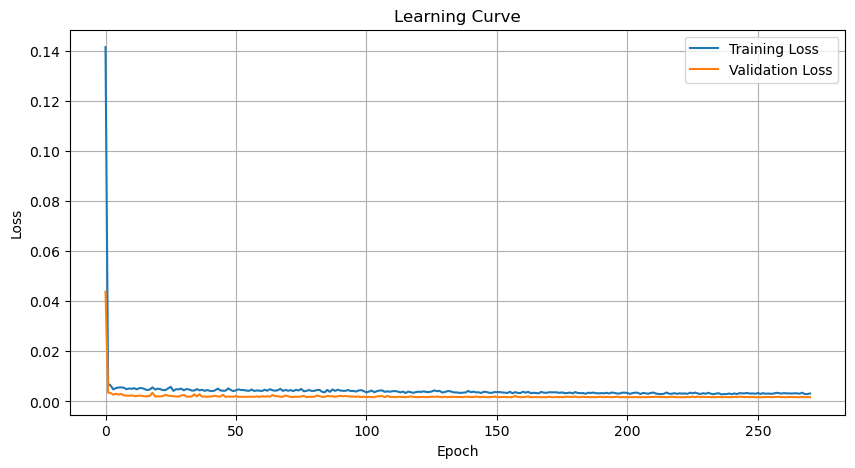

RuntimeError: GET was unable to find an engine to execute this computation

In [10]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
import numpy as np
from tqdm.notebook import tqdm
import torch.nn.functional as F
import matplotlib.pyplot as plt  # Import matplotlib for plotting

# Ensure reproducibility
torch.manual_seed(42)
np.random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

# Prepare Dataset and DataLoader
dataset = TensorDataset(initial_upsampled_signals, original_signals)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

batch_size = 32  # You can adjust this value
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


class ImprovedAutoencoder(nn.Module):
    def __init__(self):
        super(ImprovedAutoencoder, self).__init__()
        # Encoder
        self.encoder_conv1 = nn.Conv1d(1, 32, kernel_size=3, stride=1, padding=1)
        self.encoder_bn1 = nn.BatchNorm1d(32)
        
        self.encoder_conv2 = nn.Conv1d(32, 64, kernel_size=3, stride=2, padding=1)  # Downsample
        self.encoder_bn2 = nn.BatchNorm1d(64)
        
        self.encoder_conv3 = nn.Conv1d(64, 128, kernel_size=3, stride=2, padding=1)  # Downsample
        self.encoder_bn3 = nn.BatchNorm1d(128)
        
        self.encoder_conv4 = nn.Conv1d(128, 256, kernel_size=3, stride=2, padding=1)  # Downsample
        self.encoder_bn4 = nn.BatchNorm1d(256)
        
        self.relu = nn.ReLU()
        # self.dropout = nn.Dropout(0.1)
    
        # Decoder
        self.decoder_convtrans1 = nn.ConvTranspose1d(256, 128, kernel_size=4, stride=2, padding=1)  # Upsample
        self.decoder_bn1 = nn.BatchNorm1d(128)
        
        self.decoder_convtrans2 = nn.ConvTranspose1d(128, 64, kernel_size=4, stride=2, padding=1)  # Upsample
        self.decoder_bn2 = nn.BatchNorm1d(64)
        
        self.decoder_convtrans3 = nn.ConvTranspose1d(64, 32, kernel_size=4, stride=2, padding=1)  # Upsample
        self.decoder_bn3 = nn.BatchNorm1d(32)
        
        self.decoder_conv1 = nn.Conv1d(32, 1, kernel_size=3, stride=1, padding=1)  # Output layer
        
    def forward(self, x):
        # Encoder
        x1 = self.encoder_conv1(x)
        x1 = self.encoder_bn1(x1)
        x1 = self.relu(x1)
        # x1 = self.dropout(x1)
        
        x2 = self.encoder_conv2(x1)
        x2 = self.encoder_bn2(x2)
        x2 = self.relu(x2)
        # x2 = self.dropout(x2)
        
        x3 = self.encoder_conv3(x2)
        x3 = self.encoder_bn3(x3)
        x3 = self.relu(x3)
        # x3 = self.dropout(x3)
        
        x4 = self.encoder_conv4(x3)
        x4 = self.encoder_bn4(x4)
        x4 = self.relu(x4)
        # x4 = self.dropout(x4)
        
        # Decoder
        x = self.decoder_convtrans1(x4)
        x = self.decoder_bn1(x)
        x = self.relu(x)
        # x = self.dropout(x)
        
        # Add skip connection from x3
        if x3.size(2) != x.size(2):
            x3 = F.interpolate(x3, size=x.size(2))
        x = x + x3
        
        x = self.decoder_convtrans2(x)
        x = self.decoder_bn2(x)
        x = self.relu(x)
        # x = self.dropout(x)
        
        # Add skip connection from x2
        if x2.size(2) != x.size(2):
            x2 = F.interpolate(x2, size=x.size(2))
        x = x + x2
        
        x = self.decoder_convtrans3(x)
        x = self.decoder_bn3(x)
        x = self.relu(x)
        # x = self.dropout(x)
        
        # Add skip connection from x1
        if x1.size(2) != x.size(2):
            x1 = F.interpolate(x1, size=x.size(2))
        x = x + x1
        
        # Output layer
        x = self.decoder_conv1(x)
        return x

# Instantiate the model
model = ImprovedAutoencoder()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define Loss and Optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=5e-5, weight_decay=1e-5)

# Learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=20, factor=0.5)

# Initialize lists to store losses
train_losses = []
val_losses = []

# Training Loop with Early Stopping
num_epochs = 300
patience = 50  # Early stopping patience
best_val_loss = float('inf')
epochs_no_improve = 0
best_model_wts = None

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for upsampled, original in tqdm(train_loader):
        upsampled = upsampled.unsqueeze(1).to(device)  # Add channel dimension
        original = original.unsqueeze(1).to(device)

        optimizer.zero_grad()
        outputs = model(upsampled)
        loss = criterion(outputs, original)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * upsampled.size(0)

    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)  # Append training loss

    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for upsampled, original in val_loader:
            upsampled = upsampled.unsqueeze(1).to(device)
            original = original.unsqueeze(1).to(device)

            outputs = model(upsampled)
            loss = criterion(outputs, original)
            val_loss += loss.item() * upsampled.size(0)

    val_loss /= len(val_loader.dataset)
    val_losses.append(val_loss)  # Append validation loss
    scheduler.step(val_loss)

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.6f}, Val Loss: {val_loss:.6f}')

    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0
        best_model_wts = model.state_dict()
        torch.save(model.state_dict(), 'best_improved_autoencoder_4.pth')
        print(f'Validation loss decreased ({best_val_loss:.6f}). Saving model...')
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print('Early stopping!')
            break

# Load the best model weights
model.load_state_dict(best_model_wts)

# Plot the learning curve
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Learning Curve')
plt.legend()
plt.grid(True)

# Save the figure
plt.savefig('learning_curve.png', dpi=300, bbox_inches='tight')  # Save as a .png file with high resolution


plt.show()

# Evaluation on the full dataset (Optional)
model.eval()
with torch.no_grad():
    upsampled_signals = initial_upsampled_signals.unsqueeze(1).to(device)
    outputs = model(upsampled_signals)
    refined_signals = outputs.squeeze(1).cpu()


In [ ]:
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset, random_split

# Assuming initial_upsampled_signals and original_signals are already defined as torch tensors
dataset = TensorDataset(initial_upsampled_signals, original_signals)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
_, val_dataset = random_split(dataset, [train_size, val_size])

val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Function to calculate MSE loss
def calculate_mse_loss(predicted, actual):
    return ((predicted - actual) ** 2).mean()

# Calculate loss for initial interpolation on the validation set
interpolated_signals_val = []
original_signals_val = []

for upsampled, original in val_loader:
    interpolated_signals_val.append(upsampled.numpy())
    original_signals_val.append(original.numpy())

interpolated_signals_val = np.concatenate(interpolated_signals_val, axis=0)
original_signals_val = np.concatenate(original_signals_val, axis=0)

interpolation_loss_val = calculate_mse_loss(interpolated_signals_val, original_signals_val)
print(f'Interpolation Loss on Validation Set: {interpolation_loss_val}')

# Calculate loss for model's refined output on the validation set
model.eval()
refined_signals_val = []

with torch.no_grad():
    for upsampled, original in val_loader:
        upsampled = upsampled.unsqueeze(1).to(device)
        outputs = model(upsampled)
        refined_signals_val.append(outputs.cpu().numpy())

refined_signals_val = np.concatenate(refined_signals_val, axis=0)

# Calculate loss for refined signals on the validation set
refined_loss_val = calculate_mse_loss(refined_signals_val, original_signals_val)
print(f'Refined Model Loss on Validation Set: {refined_loss_val}')



In [ ]:
import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import interact

# Calculate refined signals for the validation set
model.eval()
refined_signals_val = []

with torch.no_grad():
    for upsampled, original in val_loader:
        upsampled = upsampled.unsqueeze(1).to(device)
        outputs = model(upsampled)
        refined_signals_val.append(outputs.cpu().numpy())

refined_signals_val = np.concatenate(refined_signals_val, axis=0)

def plot_comparison(signal_idx):
    interpolated_signal = interpolated_signals_val[signal_idx]
    original_signal = original_signals_val[signal_idx]
    refined_signal = refined_signals_val[signal_idx]

    # Calculate MSE loss
    mse_loss_interpolated = np.mean((interpolated_signal - original_signal) ** 2)
    mse_loss_refined = np.mean((refined_signal - original_signal) ** 2)

    plt.figure(figsize=(18, 8))
    plt.plot(original_signal.flatten(), label='Original Signal', alpha=0.7)
    plt.plot(interpolated_signal.flatten(), label=f'Interpolated Signal - MSE Loss: {mse_loss_interpolated:.4f}', alpha=0.7)
    plt.plot(refined_signal.flatten(), label=f'Refined Signal - MSE Loss: {mse_loss_refined:.4f}', alpha=0.7)
    plt.title(f'Signal {signal_idx}')
    plt.legend()
    plt.show()

# Create an interactive widget
interact(plot_comparison, signal_idx=widgets.IntSlider(min=0, max=len(interpolated_signals_val)-1, step=1, value=0))
